In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Data Cleaning

Need to remove the unusable and redundant columns

In [2]:
df = pd.read_csv('all_seasons.csv', index_col=0)
df.reset_index(inplace=True, drop = True)
df.shape

(4095, 236)

### Columns to delete:
- gf = gols for
- ga = goals against
- gf_opp = goals or the opponent
- ga_opp = goals against the opponent. 
- poss = possession, it has got x, y in the merging, will drop one and use the other. 
- Will remove ga and ga_opp as the columns are redundant. 

In [3]:
cols_todel = ['ga','match report_x','match report_y','date_opp','time_opp','comp_opp','round_opp','day_opp','venue_opp','result_opp','ga_opp','opponent_opp','xg', 'xg_y', 'match report_opp','poss_y', 'captain','referee','notes', 'attendance','formation']
df.drop(cols_todel, axis=1, inplace=True)
df.shape

(4095, 215)

Some gf and gf_opp parts have "()" in them for aggregate score. I will have to ensure they are processed correctly, I will take the value outside of the parenthesis, as that is the match sore.

In [4]:
df.loc[df["gf"].str.contains(" "),'gf'] = df["gf"].str[0] # if the Score column starts with "(", then grab the first from left char.
df.loc[df["gf_opp"].str.contains(" "),'gf_opp'] = df["gf_opp"].str[0]

## Encoding string columns

- First clean the opponent column before encoding it, the namings are not consistent


In [5]:
len(df['opponent'].unique())

523

In [6]:
df['opponent'] = df['opponent'].apply(lambda x: x[3:].lstrip() if x[0].islower() else x)  # If the format of the name starts with small letters, that is the country code. 
len(df['opponent'].unique())

459

Making team names consistent. 

In [7]:
df['opponent'] = df['opponent'].apply(lambda x:'Atletico Madrid' if x == 'Atlético Madrid' else x)
df['opponent'] = df['opponent'].apply(lambda x:'Bayer Leverkusen' if x == 'Leverkusen' else x)
df['opponent'] = df['opponent'].apply(lambda x:'Eintracht Frankfurt' if x == 'Eint Frankfurt' else x)
df['opponent'] = df['opponent'].apply(lambda x:'Internazionale' if x == 'Inter' else x)
df['opponent'] = df['opponent'].apply(lambda x:'Paris Saint Germain' if x == 'Paris S-G' else x)
df['opponent'] = df['opponent'].apply(lambda x:'Red Bull Salzburg' if x == 'RB Salzburg' else x)
df['opponent'] = df['opponent'].apply(lambda x:'Shakhtar Donetsk' if x == 'Shakhtar' else x)
df['opponent'] = df['opponent'].apply(lambda x:'Tottenham Hotspur' if x == 'Tottenham' else x)
df['opponent'] = df['opponent'].apply(lambda x:'Viktoria Plzen' if x == 'Viktoria Plzeň' else x)
len(df['opponent'].unique())

459

Checking the "team" column, the way team and opponent names are written must be consistent. 

In [8]:
print(len(df['team'].unique()))
df['team'].unique()

52


array(['Chelsea', 'Manchester City', 'Real Madrid', 'Paris Saint Germain',
       'Bayern Munich', 'Liverpool', 'Porto', 'Dortmund', 'Juventus',
       'Barcelona', 'Sevilla', 'RB Leipzig', 'Atalanta', 'Lazio',
       'Atletico Madrid', 'Monchengladbach', 'Manchester United',
       'Club Brugge', 'Shakhtar Donetsk', 'Ajax', 'Internazionale',
       'Krasnodar', 'Red Bull Salzburg', 'Dynamo Kyiv',
       'Lokomotiv Moscow', 'Olympiacos', 'Istanbul Basaksehir',
       'Marseille', 'Midtjylland', 'Rennes', 'Zenit', 'Ferencvaros',
       'Villarreal', 'Benfica', 'Lille', 'Sporting CP',
       'Sheriff Tiraspol', 'Young Boys', 'Wolfsburg', 'Milan', 'Malmo',
       'Besiktas', 'Napoli', 'Tottenham Hotspur', 'Eintracht Frankfurt',
       'Bayer Leverkusen', 'Dinamo Zagreb', 'FC Copenhagen',
       'Maccabi Haifa', 'Celtic', 'Viktoria Plzen', 'Rangers'],
      dtype=object)

Now encode the rest of the information rich categorical columns.

In [9]:
df['date'] = pd.to_datetime(df['date'],dayfirst=True)
df["venue_code"] = df["venue"].astype("category").cat.codes
df["opp_code"] = df["opponent"].astype("category").cat.codes #
df['round_code'] = df['round'].astype('category').cat.codes
df['comp_code'] = df['comp'].astype('category').cat.codes
#df['formation_code'] = df['formation'].astype('category').cat.codes decided not to use it as we won't have concrete information on it.


df["hour"] = df["time"].str.replace(":.+", "", regex=True).astype("int")
df["day_code"] = df["date"].dt.dayofweek

df.head()

,date,time,comp,round,day,venue,result,gf,opponent,gls,...,won%_opp,xga,team,season,venue_code,opp_code,round_code,comp_code,hour,day_code
0,2020-09-14,20:15,Premier League,Matchweek 1,Mon,Away,W,3,Brighton,3.0,...,43.5,1.1,Chelsea,2020-2021,0,73,12,19,20,0
1,2020-09-20,16:30,Premier League,Matchweek 2,Sun,Home,L,0,Liverpool,0.0,...,21.4,2.1,Chelsea,2020-2021,1,229,23,19,16,6
2,2020-09-23,19:45,EFL Cup,Third round,Wed,Home,W,6,Barnsley,6.0,...,NaN,NaN,Chelsea,2020-2021,1,50,66,10,19,2
3,2020-09-26,17:30,Premier League,Matchweek 3,Sat,Away,D,3,West Brom,3.0,...,39.3,0.6,Chelsea,2020-2021,0,435,34,19,17,5
4,2020-09-29,19:45,EFL Cup,Fourth round,Tue,Away,D,1,Tottenham Hotspur,1.0,...,NaN,NaN,Chelsea,2020-2021,0,395,8,10,19,1


## Missing Data
Deleting rows that are missing a lot of stats. Already have very high dimensionality, and not enough data or this many dimensions, so wil remove some of the stat columns. Let us have a visual on the missing values in all the columns. 

(4095, 221)

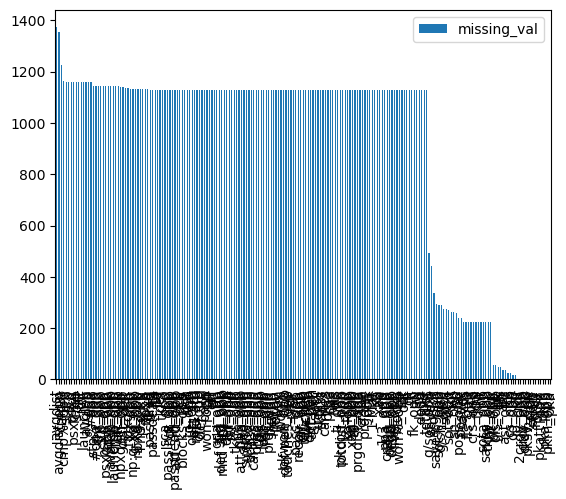

In [10]:
missing = pd.DataFrame(df.isnull().sum().sort_values(ascending=False))
missing.rename(columns={0:'missing_val'}, inplace=True)
missing[missing['missing_val']>0].plot.bar()

df.shape

We can see that the number of missing values drops down in a step function. So we delete the columns that have over 300 missing values and the rows for anything less than that. This is the sweet spot as deleting more columns or rows will impact the quality of our data. 
Also, the relationship between various features in football matches is highly (e.g the opponent team) so imputation is not the answer here as it may affect the quality of the data too much.

In [11]:
cols_todel2 = missing[missing['missing_val']>300].index
df.drop(list(cols_todel2), axis=1, inplace=True)
df.shape

(4095, 67)

Of course if one is interested, one can use these columns with the rows that have them, but I choose to have lower dimensionality and more data rows. 

In [12]:
df = df.dropna(axis = 0) #drop rows with missing values
# df = df.reset_index(drop=True)
df.shape # and no missing values.

(3714, 67)

In [13]:
clean_df = [df]
pickle.dump(df,open('clean_df.pkl','wb'))

Everything that has to be numeric is already numeric. Let us make a target variable first (please the prediction notebook)